# Cognitive Algorithms - Assignment 5 (30 points)
Cognitive Algorithms        
Summer Term 2020      
Technische Universität Berlin     
Fachgebiet Maschinelles Lernen 
                    
**Respective quiz due on July 1, 2020 23:59 via ISIS**

**Answer the questions on Isis in 'Assignment 5 - Quiz' and copy code from this notebook where necessary.**

In [1]:
import numpy as np
import matplotlib.pyplot as pl

In [2]:
%matplotlib inline
pl.style.use('ggplot')

### Task 1: Principal Component Analysis (16 points)
In this assignment, you will detect trends in text data and implement Principal Component Analysis (PCA). The text data consists of preprocessed news feeds gathered from http://beta.wunderfacts.com/ in October 2011, and you will be able to detect  a trend related to Steve Jobs death on 5th October 2011. 

The data consists of 26800 Bag-of-Words (BOW) features of news published every hour, i.e. the news are represented in a vector which contains the occurence of each word. Here we have many more dimensions (26800) than data points (645). This is why we will implement Linear Kernel PCA instead of standard PCA. 

Download the dataset ```newsdata.npz``` from Isis, if not done yet.  

In [3]:
def pca(X, ncomp=10):
    ''' Principal Component Analysis
    INPUT:  X       - dxn array of n data points with d features
            ncomp   - number of principal components to estimate 
    OUTPUT: W       - d x ncomp array of directions of maximal variance, 
                     sorted by their eigenvalues
            H       - ncomp x n array of projected data '''
    
    ncomp = min(np.hstack((X.shape, ncomp)))
    #  ... your code here ...
    X = X-np.mean(X,axis=1)[:,None]                # center the data
    K = X.T@X                                      # compute linear kernel
    
    EW,EV = np.linalg.eigh(K)                      # compute eigenvalues and eigenvectors
    EWEV = np.concatenate((EW[:,None],EV), axis=1) # concatenate EW and EV to sort
    EWEV_revsort = EWEV[EWEV[:,0].argsort()[::-1]] # sort reverse EWEV by EW
    alpha = EWEV_revsort[:ncomp,1:]                # k largest EV

    W = X@alpha.T
    m,n = W.shape
    if m == n:
        EW,EV = np.linalg.eigh(W)
        EWEV = np.concatenate((EW[:,None],EV), axis=1) # concatenate EW and EV to sort
        EWEV_revsort = EWEV[EWEV[:,0].argsort()[::-1]] # sort reverse EWEV by EW
        W = EWEV_revsort[:,1:]                         # W sorted by EW
    
    H = W.T@X
    
    return W, H

In [4]:
# Quiz5 from isis
# create random rotated data
X = np.array([[0,0],[1,2]])
X = X-np.mean(X,axis=1)[:,None]                # center the data
C = 1/(len(X))*X@X.T                           # compute cov. mat.

EW,EV = np.linalg.eigh(C)                      # compute eigenvalues and eigenvectors
W = EV
H = W.T*X
EW,W,H

(array([0.  , 0.25]),
 array([[1., 0.],
        [0., 1.]]),
 array([[ 0. ,  0. ],
        [-0. ,  0.5]]))

In [5]:
# Test from isis
# create random rotated data
np.random.seed(1)
X = np.array([[1,2],[0,2]]) @ np.random.randn(2,300)
# apply liner kernel pca
W, H = pca(X,2)
# normalize eigenvectors (non normalized because of kernel context)
W = W / np.diag(W.T @ W)[None, :]
# project back to original space
R = W @ H
# compare to X normalized
Xn = X - X.mean(axis=1, keepdims=True)
print(np.allclose(R, Xn))

True


In [6]:
# Test from isis
# create random rotated data
np.random.seed(1)
X = np.random.rand(20,20) @ np.random.rand(20,300)
# apply liner kernel pca
W, H = pca(X,20)
# normalize eigenvectors (non normalized because of kernel context)
W = W / np.diag(W.T @ W)[None, :]
# project back to original space
R = W @ H
# compare to X normalized
Xn = X - X.mean(axis=1, keepdims=True)
print(np.allclose(R, Xn))

True


In [7]:
def nmf(X,ncomp=10,its=100):
    '''Non-negative matrix factorization as in Lee and Seung http://dx.doi.org/10.1038/44565
    INPUT:  X       -  DxN array of N data points with D features
            ncomp   - number of factors to estimate
            its     - number of iterations
    OUTPUT: W       - D x ncomp array
            H       - ncomp x N array ''' 
 
    ncomp = min(np.hstack((X.shape, 10)))
    X = X + 1e-19
    # initialize randomly
    W = np.random.rand(X.shape[0], ncomp)
    H = np.random.rand(X.shape[1], ncomp).T
    # update for its iterations
    for it in np.arange(its):
        H = H * (W.T.dot(X) / (W.T.dot(W.dot(H))))
        W = W * (X.dot(H.T) / (W.dot(H.dot(H.T))))
    return W,H

In [8]:
def get_data(fname='newsdata_BOW.npz'):
    data = np.load(fname, encoding='latin1', allow_pickle=True)
    dates = data['dates']
    BOW = np.array(data['BOW_features'].tolist().todense())
    words = data['words']
    return BOW, words, dates

In [9]:
def remove_word_stubs(BOW, words):
    stubs = ['wa', 'ha', "n't", '’', '–', "'re",'--', "'s", '“', '”']
    for stub in stubs:
        index = np.where(words==stub)
        words = np.delete(words, index)
        BOW = np.delete(BOW, index, axis=0)
    return BOW, words

In [10]:
def plot_trends(ntopics=8,method=nmf,topwhat=10):
    #load data
    BOW, words, dates = get_data()
    BOW, words = remove_word_stubs(BOW, words)
    topics, trends = method(BOW, ntopics)
    for itopic in range(ntopics):
        pl.figure(figsize=(8, 6))
        pl.plot(trends[itopic, :].T)
        ranks = (-abs(topics[:, itopic])).argsort()
        thislabel = words[ranks[:topwhat]]
        thislabel = [str(i) for i in thislabel]
        pl.legend([thislabel])
        days = np.arange(0, BOW.shape[-1], 24*7)
        pl.xticks(days, dates[days], rotation=20)
        pl.show()

In [11]:
def test_assignment6():
    ##Example 1
    X = np.array([[0, 1], [0, 1]])
    W, H = pca(X, ncomp = 1)
    assert np.all(W / W[0] == [[1], [1]])
    print('2 datapoint test passed')
    
    ##Example 2
    #generate 2D data
    N =100
    cov = np.array([[10, 4], [4, 5]])
    X = np.random.multivariate_normal([0, -20], cov, N).T
    #do pca 
    W, H = pca(X)
    #plot result
    pl.figure()
    pc0 = 10 * W[:,0] / np.linalg.norm(W[:,0])
    pc1 = 10 * W[:,1] / np.linalg.norm(W[:,1])
    pl.plot([-pc0[0], pc0[0]], [-pc0[1] - 20, pc0[1] - 20], '-k', label='1st PC')
    pl.plot([-pc1[0], pc1[0]], [-pc1[1] - 20, pc1[1] - 20], '-.r', label='2nd PC')
    pl.plot(X[0, :], X[1, :], '+', color='k')
    pl.axis('equal')
    pl.legend(loc=1)
    pl.show()

**A)** Implement Linear Kernel Principal Component Analysis  by completing the function stub  ```pca```.  Given data $X \in \mathbb{R}^{d \times n}$, PCA finds a decomposition of the data in $k$ orthogonal principal components that maximize the variance in the data, 

$$X = W \cdot H$$ 

with $W \in \mathbb{R}^{d \times k}$ and   $H \in \mathbb{R}^{k \times n}$. The  Pseudocode is given below. The function  ```test_assignment6``` helps you to debug your code. It plots for a 2D data set the two principal components. 
                           
```PCA( X, k ):```                           
1. ```# Require: data``` $x_1, \ldots, x_n \in \mathbb R^d$, $n\ll d$ ```, number of principal components``` $k$                           
1. ```# Center Data```                           
1. $\; \; \; X = X - \frac{1}{n}\sum_ix_i$                           
1. ```# Compute Linear Kernel```                           
1. $\; \; \; K = X^{\top}X$                           
1. ```# Compute eigenvectors corresponding to the``` $k$ ```largest eigenvalues```                           
1. $\; \; \; \alpha = \text{eig}(K)$                           
1. $\; \; \;  W = X \alpha$                           
1. ```# Project data onto``` $W$                           
1. $\; \; \; H = W^\top X$                           
1. ```return W, H```                           

**B)** What happens when you forget to center the data in ```pca```? Show the resulting plot for the 2D toydata.

2 datapoint test passed


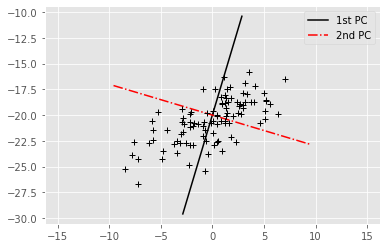

In [12]:
test_assignment6()

**D)** Detect trends in the text data by calling the provided function ```plot_trends``` once for PCA and once for Non-Negative Matrix Factorization (NMF) (the code for NMF is provided as well). Which differences do you notice between the algorithms? Which method would you prefer for this task? Hand in the plot of the most prominent trend related to Steve Jobs death for each algorithm.  

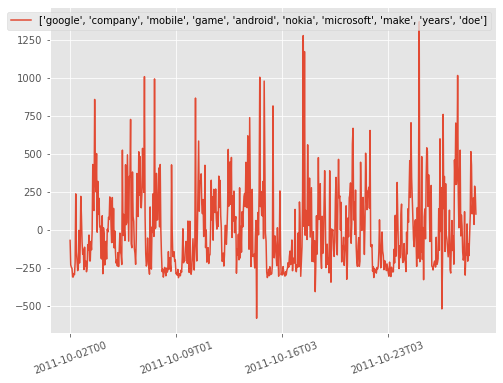

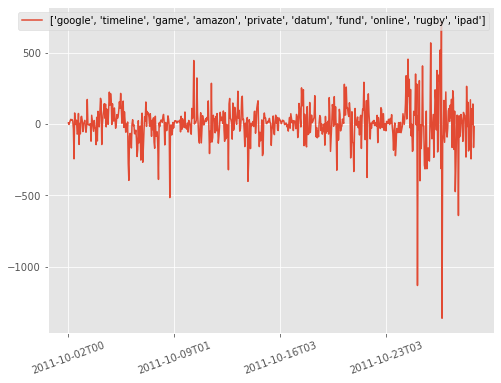

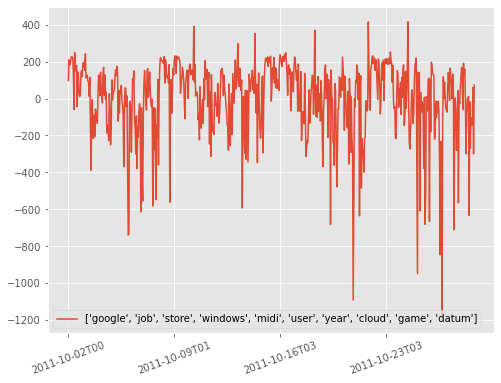

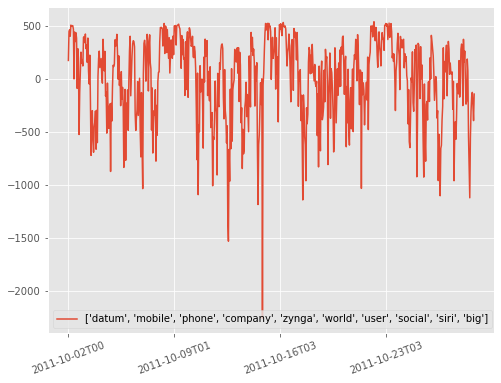

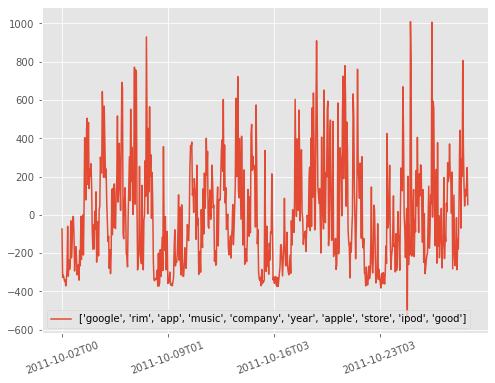

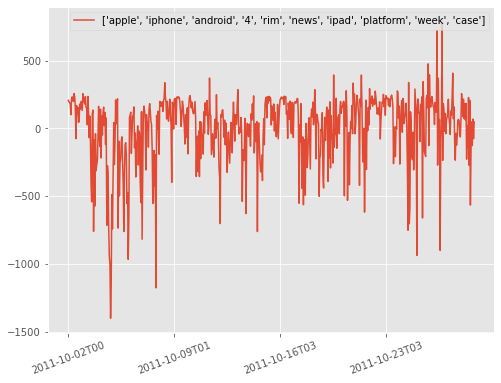

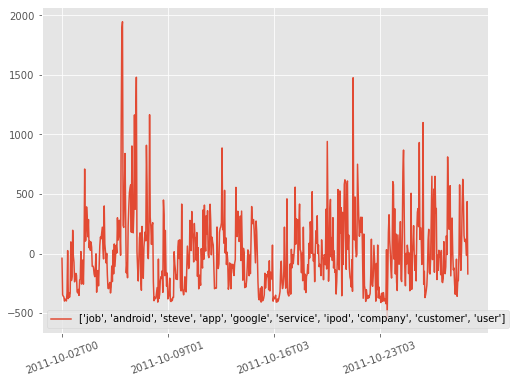

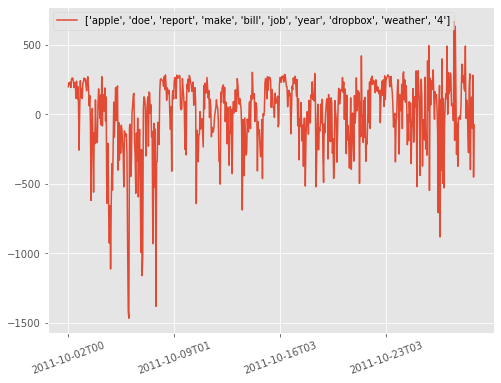

In [13]:
plot_trends(method=pca)

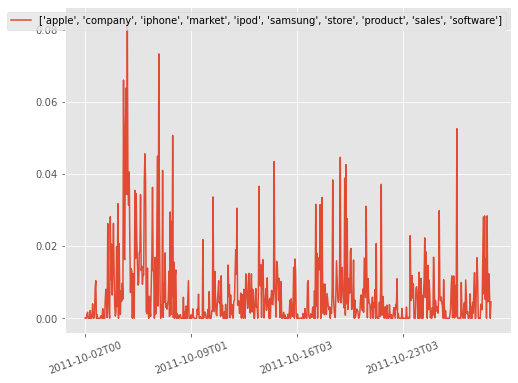

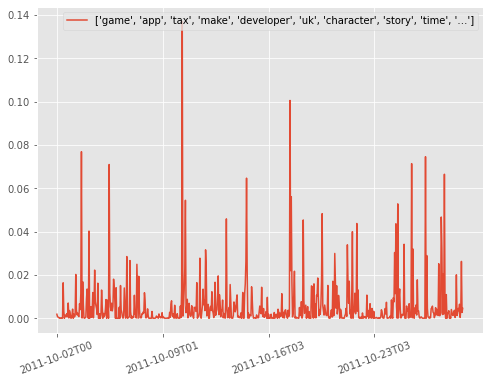

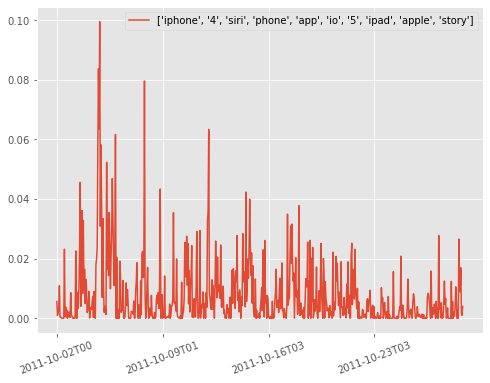

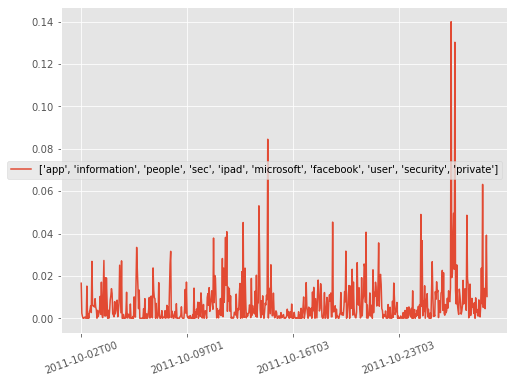

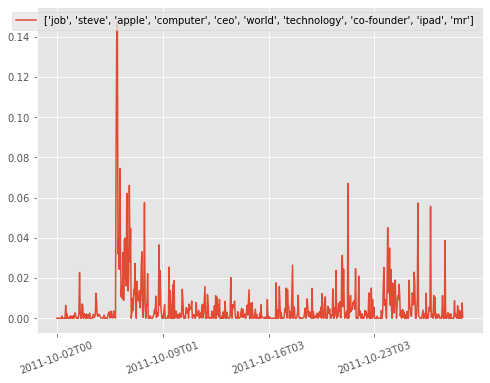

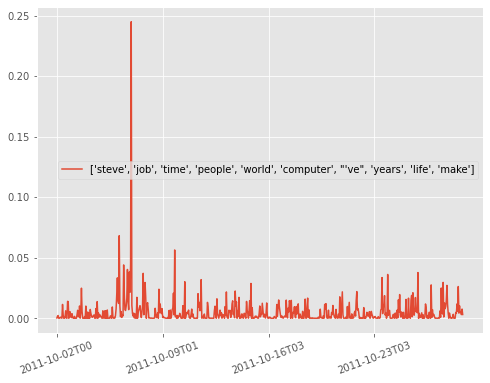

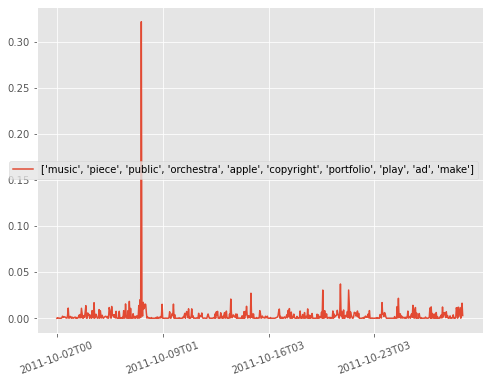

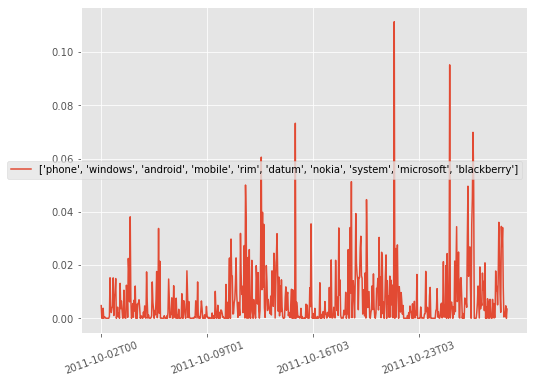

In [14]:
plot_trends(method=nmf)

### Task 2: K-Means Clustering (9 points)
In this exercise we want to implement the $k$-Means Clustering algorithm. It finds cluster centers $\mu_1 \ldots \mu_k$ such that the distance of the data points to their respective cluster center are minimized. This is done by re-iterating two steps:
1. Assign each data point $x_i$ to their closest cluster $\mu_k$ (for all $i = 1 \ldots n$)
1. Update each cluster center $\mu_j$ to the mean of the members in that cluster $j$ (for all $j = 1 \ldots k$)

Complete the function ```kmeans``` (see Task 2.A to 2.D for more detail). ```test_kmeans``` helps you to debug your code. It generates a simple 2D toy dataset. Your ```kmeans``` implementation should correctly identify the three clusters and should converge after only a few iterations (less than 10).

**A)** Initialize the centroids. To do so calculate the mean of the whole data set and add some standard normal distributed noise to it, i.e. for all $i = 1 \ldots k$

$$\mu_i = \bar{x} + \epsilon_i$$

where $\bar{x}, \epsilon_i \in \mathbb{R}^d$ and $\bar{x} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{x_i}$ and $\epsilon_i \sim \mathcal{N}(\mathbf{0}, I)$ 

**B)** For step 1 of the algorithm, we need the distance between each data point $x_i$ and each centroid $\mu_j$. Complete the function ```distmat``` that calculates a matrix $Dist \in \mathbb{R}^{n, k}$ such that 

$$Dist_{i,j} = || x_i - \mu_j ||^2 $$

We can calculate the matrix $Dist$ without the use of for-loops by using following formula:

$$Dist = A - 2 B + C  $$

where $A_{i,j} = x_i^T x_i,\,B_{i,j} = x_i^T \mu_j$ and $ C_{i,j} = \mu_j^T \mu_j$

**C)** Assign each data point to its closest centroid. To do so, construct a matrix $Closest \in \mathbb{R}^{n,k}$ such that 

$$Closest_{i,j} = \begin{cases} True & \; \; \tt{if} \; \; \mu_j \text{ is the closest centroid to } x_i \\ False & \; \; \text{otherwise} \end{cases}$$

i.e. each row of $Closest$ holds only one ```True``` element.

**D)** Update each cluster center to the mean of the members in that cluster, i.e. for all $j = 1 \ldots k$ 

$$\mu_j = \frac{1}{|{\mathcal{X_j}}|} \sum_{x \in \mathcal{X_j}} x$$ 

$$\mathcal{X_j} = \{ x_i \in X \; | \text{ the closest centroid to } x_i \text{ is } \mu_j \}$$

In [15]:
def test_kmeans():
    #generate 2D data
    N =500
    cov = np.array([[1, 0], [0, 0.5]])
    # generate for each of the three clusters N data points
    x1 = np.random.multivariate_normal([-2, 2], cov, N) 
    x2 = np.random.multivariate_normal([2, 2], cov, N) 
    x3 = np.random.multivariate_normal([-2, -2], cov, N)
    X = np.vstack((x1, x2, x3)).transpose()
    
    # run kmeans and plot the result
    centroids, closest = kmeans(X, 3)
    plot_cluster(X, centroids, closest)

In [16]:
def plot_cluster(X, centroids, closest):
    K = np.shape(centroids)[1]
    pl.figure()
    pl.scatter(X[0], X[1])
    if (closest != np.zeros(np.shape(closest))).any():
        for k in range(K):
            # get for each centroid the assigned data points
            Xk = X[:, closest[:,k]]
            # plot each cluster in a different color
            pl.scatter(Xk[0], Xk[1])

    # plot each centroid (should be center of cloud)
    pl.scatter(centroids[0], centroids[1])

In [17]:
def kmeans(X, k, max_iter=50, eta=0.01):
    """ k-Means Clustering
    INPUT:  X            - DxN array of N data points with D features
            k            - number of clusters
            max_iter     - maximum number of iterations
            eta          - small threshold for convergence criterion
    OUTPUT: centroids    - dxk array of K centroids with D features
            closest      - nxk array that indicates for each of the N data points
                           in X the closest centroid after convergence.
                           Each row in closest only holds one non-zero entry. 
                           closest[i, j] == 1 <=> 
                           centroids[:, j] is closest to data point X[:, i]
    """

    d, n = np.shape(X)
    dist = np.zeros((n, k))
    closest = np.zeros((n, k))

    # initialize the centroids (close to the mean of X)
    # ... your code here ...
    mean = np.mean(X,axis=1)                 # mean of X
    eps = np.random.normal(0, 1, size=(d,k)) # noise for centroids
    centroids = mean[:,None] + eps           # compute the matrix of centroids (d x k)

    cur_iter = 0
    while cur_iter < max_iter:
#        print(cur_iter,centroids,np.shape(centroids))
        plot_cluster(X, centroids, closest)
        cur_iter += 1
        old_centroids = centroids.copy()
    
        # --- expectation step --- 
        # e. g. for each data point, which cluster do we expect it to belong to?
        # calculate the distance between each data point and each centroid
        dist = distmat(X, centroids)
    
        # get for each data point in X it's closest centroid
        closest = get_closest(dist)
        
        # --- maximization set --- : 
        # e. g. for each cluster, which point maximally covers the assigned data points?
        # update the estimation of the centroids
        centroids = update_centroids(X, closest)
        
        if np.linalg.norm(old_centroids - centroids) < eta:
            print('Converged after ' + str(cur_iter) + ' iterations.')
            break

    return centroids, closest

In [18]:
def distmat(X, Y):
    """ Distance Matrix
    INPUT:      X           - dxn array of N data points with d features
                Y           - dxm array of M data points with d features
    OUTPUT:     distmat     - nxm array s.t. D[i, j] = || x_i - y_j ||^2
    Hint: np.tile might be helpful
    """

    d, n = np.shape(X)
    d_y, m = np.shape(Y)
    assert d == d_y
    
    # calculate the distance matrix
    # ... your code here ...
#    A = X.T@X
#    B = X.T@Y
#    C = Y.T@Y
#    dsit = A - 2*B + C
    dist = np.sum((X-Y.T[:,:,None])**2,axis=1).T

    return dist

In [19]:
def get_closest(dist):
    """ Distance Matrix
    INPUT:      dist       - nxm array of distance between data point n and m
    OUTPUT:     closest    - nxk array that indicates for each of the N data points
                             in X the closest centroid in current iteration.
                             Each row in closest only holds one non-zero entry. 
                             closest[i, j] == 1 <=> 
                             centroids[:, j] is closest to data point X[:, i]
    """
    
    n, k = dist.shape
    closest = np.zeros((n, k), dtype='bool')
    
    # compute the matrix indicating the closest centroid
    # ... your code here ...
    closest = dist == np.min(dist,axis=1)[:,None] # in each row one True ()

    return closest

In [20]:
def update_centroids(X, closest):
    """
    INPUT:  X            - dxn array of N data points with D features
            closest      - nxk array that indicates for each of the N data points
                           in X the closest centroid after convergence.
                           Each row in closest only holds one non-zero entry. 
                           closest[i, j] == 1 <=> 
                           centroids[:, j] is closest to data point X[:, i]
    OUTPUT: centroids    - dxk array of k centroids with d features
    """
    
    # ... your code here ...
    d,n = X.shape
    _,k = closest.shape
    centroids = np.zeros((d,k))
    for i in range(k):                                     # k mask from closest for X
        centroids[:,i] = np.mean(X[:,closest[:,i]],axis=1) # mean from X[:,mask]

    return centroids

Converged after 6 iterations.


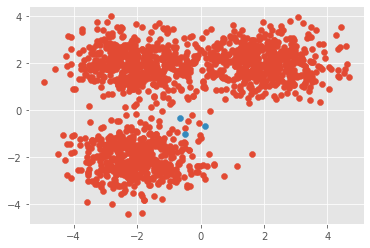

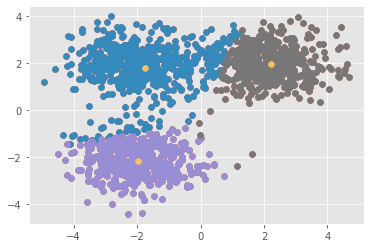

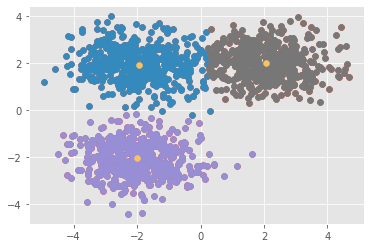

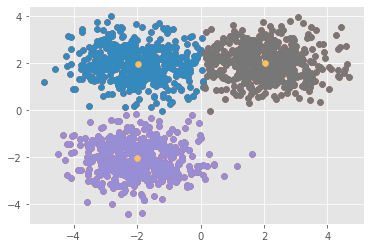

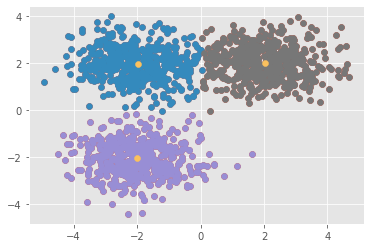

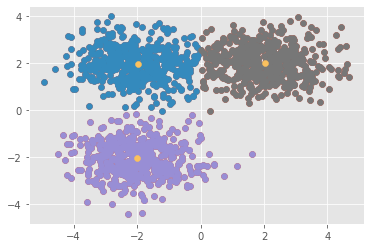

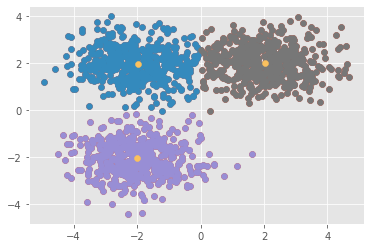

In [21]:
test_kmeans()